# Compare 2 videos with SSIM and PSNR metrics

The classic metrics **PSNR** (Peak Signal to Noise Ratio) and SSIM (Structural SIMilarity) are implemented in C for improved performance.

In [1]:
import math
import pathlib
import timeit

import cv2
import numpy as np
import tqdm

from cutcutcodec.core.io import read
from cutcutcodec.core.opti.parallel import starmap
from cutcutcodec.core.signal.metric import psnr as compute_psnr, ssim as compute_ssim  # the main functions

## Preparing videos to be compared
Here we'll compare the original video with a noisy version.

In [2]:
from cutcutcodec.core.analysis.stream.rate_video import optimal_rate_video
from cutcutcodec.core.analysis.stream.shape import optimal_shape_video
from cutcutcodec.utils import get_project_root

file = get_project_root().parent / "media" / "video" / "intro.webm"
stream_ref = read(file).out_select("video")[0]
rate = optimal_rate_video(stream_ref)
shape = optimal_shape_video(stream_ref)
print(f"{file} at {rate} fps, of size {shape[1]}x{shape[0]}")

/data/Documents/cutcutcodec_git/media/video/intro.webm at 30000/1001 fps, of size 1280x720


In [3]:
from cutcutcodec.core.filter.video.equation import FilterVideoEquation
from cutcutcodec.core.generation.video.noise import GeneratorVideoNoise

noise = GeneratorVideoNoise(0).out_streams[0]
stream_comp = FilterVideoEquation([stream_ref, noise], "(9*b0+b1)/10", "(9*g0+g1)/10", "(9*r0+r1)/10").out_streams[0]

## Compare each frame

### Convert all streams into YUV in the same colorspace
Image comparisons are always made in yuv, not rgb.

In [4]:
from cutcutcodec.core.filter.video.colorspace import FilterVideoColorspace
from cutcutcodec.config import Config  # to get the default used colorspace

dst_color = f"y'pbpr_{Config().target_trc}_{Config().target_prim}"
ref_yuv = FilterVideoColorspace([stream_ref], dst=dst_color).out_streams[0]
comp_yuv = FilterVideoColorspace([stream_comp], dst=dst_color).out_streams[0]

In [5]:
def compare(stream1, stream2, time, shape):
    """Compare 2 images."""
    frame1, frame2 = stream1.snapshot(time, shape), stream2.snapshot(time, shape)
    frame1, frame2 = frame1.numpy(force=True), frame2.numpy(force=True)
    psnr = compute_psnr(frame1, frame2, weights=(6, 1, 1))  # factor 6 on y
    ssim = compute_ssim(frame1, frame2, weights=(6, 1, 1), data_range=1.0)
    return psnr, ssim

In [6]:
times = np.arange(0, ref_yuv.duration, 1/rate).tolist()
all_psnr, all_ssim = zip(*starmap(compare, ((ref_yuv, comp_yuv, t, shape) for t in tqdm.tqdm(times))))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [00:46<00:00,  6.31it/s]


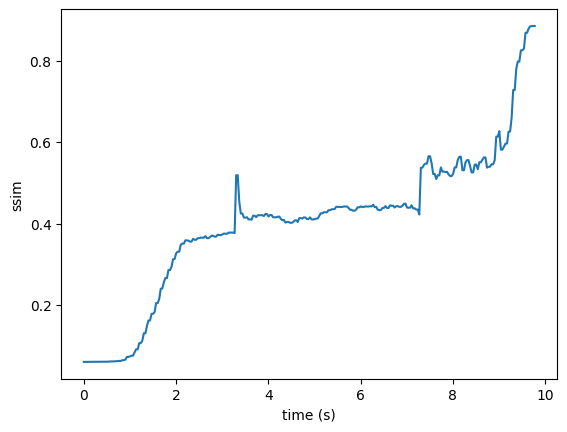

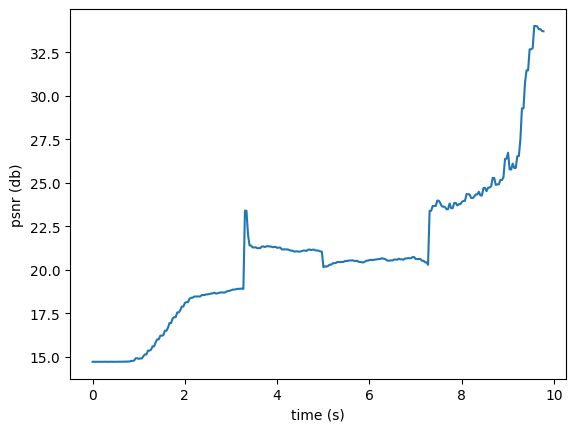

In [7]:
import matplotlib.pyplot as plt

plt.plot(times, all_ssim)
plt.xlabel("time (s)")
plt.ylabel("ssim")
plt.show()

plt.plot(times, all_psnr)
plt.xlabel("time (s)")
plt.ylabel("psnr (db)")
plt.show()

## Compare performances on syntetic data

In [8]:
# Functions as implemented in classical libraries.

def naive_psnr(im1: np.ndarray, im2: np.ndarray, weights = None) -> float:
    """Compute the psnr with numpy."""
    if weights is None:
      weights = [1.0 for _ in range(im1.shape[2])]
    layers_mse = ((im1 - im2)**2).mean(axis=(0, 1)).tolist()
    tot = sum(weights)
    mse = sum(l*w/tot for w, l in zip(weights, layers_mse))
    return -10.0*math.log10(mse) if mse > 1e-10 else 100.0

def naive_ssim(
  im1: np.ndarray, im2: np.ndarray, data_range : float = 1.0, weights = None, sigma: float = 1.5
) -> float:
    """Compute the ssim with numpy and cv2."""
    # get gaussian window
    r = int(3.5 * sigma + 0.5)  # same as skimage.metrics.structural_similarity
    gauss = np.exp(-(np.arange(-r, r+1)**2) / (2.0 * sigma**2))
    gauss_i, gauss_j = np.meshgrid(gauss, gauss, indexing="ij")
    gauss = gauss_i * gauss_j
    gauss /= gauss.sum()
    # compute statistics for all patches
    mu1 = cv2.filter2D(im1, ddepth=-1, kernel=gauss)
    mu2 = cv2.filter2D(im2, ddepth=-1, kernel=gauss)
    mu11, mu22, mu12 = mu1 * mu1, mu2 * mu2, mu1 * mu2
    s11 = cv2.filter2D(im1*im1, ddepth=-1, kernel=gauss) - mu11
    s22 = cv2.filter2D(im2*im2, ddepth=-1, kernel=gauss) - mu22
    s12 = cv2.filter2D(im1*im2, ddepth=-1, kernel=gauss) - mu12
    # crop patches
    mu11, mu22, mu12 = mu11[r:-r, r:-r], mu22[r:-r, r:-r], mu12[r:-r, r:-r]
    s11, s22, s12 = s11[r:-r, r:-r], s22[r:-r, r:-r], s12[r:-r, r:-r]
    # ssim formula
    c1, c2 = (0.01 * data_range)**2, (0.03 * data_range)**2
    ssim = ((2.0*mu12 + c1) * (2.0*s12 + c2)) / ((mu11 + mu22 + c1) * (s11 + s22 + c2))
    # average
    if weights is None:
      weights = [1.0 for _ in range(im1.shape[2])]
    weights = np.asarray(weights, dtype=im1.dtype)
    return float((ssim.mean(axis=(0, 1)) * weights).sum() / weights.sum())


In [9]:
# Create syntetic 4k images.

shape = (2160, 3840, 3)  # 4k
# shape = (1080, 1920, 3)  # full hd
im1 = np.random.random((2160, 3840, 3))
im2 = 0.8*im1 + 0.2*np.random.random((2160, 3840, 3))
im1, im2 = im1.astype(np.float32), im2.astype(np.float32)

In [10]:
time_naive_psnr = min(timeit.repeat(lambda: naive_psnr(im1, im2), repeat=5, number=10)) / 10
time_c_psnr = min(timeit.repeat(lambda: compute_psnr(im1, im2), repeat=5, number=10)) / 10
print(f"PSNR: {1000*time_naive_psnr:.1f}ms vs {1000*time_c_psnr:.1f}ms")

PSNR: 120.8ms vs 4.9ms


In [11]:
time_naive_ssim = min(timeit.repeat(lambda: naive_ssim(im1, im2, data_range=1.0), repeat=3, number=10)) / 10
time_c_ssim = min(timeit.repeat(lambda: compute_ssim(im1, im2, data_range=1.0), repeat=3, number=10)) / 10
print(f"SSIM: {1000*time_naive_ssim:.1f}ms vs {1000*time_c_ssim:.1f}ms")

SSIM: 1111.5ms vs 502.3ms
